# Multidimensional Scaling

In [1]:
import polars as pl
import polars.selectors as ps
import pandas as pd
import numpy as np
from scipy.spatial.distance import euclidean, cityblock, cosine, squareform, pdist
import sklearn.metrics.pairwise
from sklearn.manifold import MDS, TSNE
import seaborn as sns
import folium
# Import matplotlib for 3d plotting:
import matplotlib.pyplot as plt
from sklearn.preprocessing import  MinMaxScaler
from matplotlib import offsetbox
# Make matplotlib work in jupyter notebook
%matplotlib inline

Multidimensional Scaling is the overarching family name of algorithms like PCA, where data is embedded in a different dimension space than the original data. Often a practical use is to visualise data in a lower dimension.

## Metric MDS

With Metric MDS represents points in a D-dimensional space by preserving the metric on that space and projecting onto a lower dimensional space. This is done by building a matrix of all distances

$$
D_{ij} = d(x_i, x_j)
$$

and minimizing the following cost function (referred to as *stress*)

$$
    \text{Stress}_D (\vec{z}) = \sqrt{\sum_{i\neq j = 1}^{n} \left( d_{ij} - || z_i - z_j ||^2\right)}
$$

which is the residual sum of squares for the difference between the original distance $d_{ij}$ and the new embeddings $|| z_i - z_j ||^2$.

### Example

As an illustration of how this works, we can use it to find the position of cities on the globe. This position is expressed in (latitude, longitude) coordinate space, where:

- latitude =>  $\phi\in [0, 90]$
- longitude => $\lambda \in [0, 180]$ 

However, we only have data on distances between cities in matrix form. These distances can be interpreted as a dissimilarity metric and thus is a great method for testing out the MDS algorithm.

The data below is the relative latitude between each city pair: $d_{ij} = | l_i - l_j |$.

In [3]:
df = pd.read_csv("./data/distance.csv").set_index("name")
df

,Buenos Aires,Paris,Melbourne,St Petersbourg,Abidjan,Montreal,Nairobi,Salvador
name,,,,,,,,
Buenos Aires,0.00,83.00,4.00,93.93,39.33,79.52,32.71,21.03
Paris,83.00,0.00,87.00,10.93,43.67,3.48,50.29,61.97
Melbourne,4.00,87.00,0.00,97.93,43.33,83.52,36.71,25.03
St Petersbourg,93.93,10.93,97.93,0.00,54.60,14.41,61.22,72.90
Abidjan,39.33,43.67,43.33,54.60,0.00,40.19,6.62,18.30
Montreal,79.52,3.48,83.52,14.41,40.19,0.00,46.81,58.49
Nairobi,32.71,50.29,36.71,61.22,6.62,46.81,0.00,11.68
Salvador,21.03,61.97,25.03,72.90,18.30,58.49,11.68,0.00


We can also easily create this data ourselves by using the actual latitude and longitude positions of these cities. However, it is more interstin to look at the combination of relative latitude and longitude

In [4]:
lat_long_pos = pl.DataFrame(
    {
        'name': ['Buenos Aires', 'Paris', 'Melbourne', 'St Petersbourg',
                 'Abidjan', 'Montreal', 'Nairobi', 'Salvador'],
        'lon': [-58, 2, 145, 30.32, -4.03, -73.57, 36.82, -38.5],
        'lat': [-34, 49, -38, 59.93, 5.33, 45.52, -1.29, -12.97],
    },
    strict=False
)

df = (
    lat_long_pos
    .select(["name", "lat", "lon"])
    .pipe(
        lambda cities: cities.join(cities, how='cross', suffix='_j')
    )
    .with_columns(
        (
            (pl.col("lat") - pl.col("lat_j")).abs()
            + (pl.col("lon") - pl.col("lon_j")).abs()
        ).alias("distance")
    )
    .select("name", "name_j", "distance")
    .pivot(values="distance", index="name", on="name_j")
)

# Select just the numeric columns
data = df.select(ps.numeric())
data_columns = data.columns

df

name,Buenos Aires,Paris,Melbourne,St Petersbourg,Abidjan,Montreal,Nairobi,Salvador
str,f64,f64,f64,f64,f64,f64,f64,f64
"""Buenos Aires""",0.0,143.0,207.0,182.25,93.3,95.09,127.53,40.53
"""Paris""",143.0,0.0,230.0,39.25,49.7,79.05,85.11,102.47
"""Melbourne""",207.0,230.0,0.0,212.61,192.36,302.09,144.89,208.53
"""St Petersbourg""",182.25,39.25,212.61,0.0,88.95,118.3,67.72,141.72
"""Abidjan""",93.3,49.7,192.36,88.95,0.0,109.73,47.47,52.77
"""Montreal""",95.09,79.05,302.09,118.3,109.73,0.0,157.2,93.56
"""Nairobi""",127.53,85.11,144.89,67.72,47.47,157.2,0.0,87.0
"""Salvador""",40.53,102.47,208.53,141.72,52.77,93.56,87.0,0.0


In [5]:
embedding = MDS(
    dissimilarity='precomputed',
    n_components=2,
    random_state=0,
    max_iter=300,
    eps=1e-3,
    n_init=4
)

X_transformed = embedding.fit_transform(data)

We choose to take 2 components to see if we can recover the relation between city positions and relative latitude. Hopefully we can interpret these components as latitude and longitude.

In [6]:
city_names = pl.DataFrame(lat_long_pos["name"], schema=["name"])

embedded_df = city_names.hstack(pl.DataFrame(X_transformed, schema=['lat', 'lon']))

Let's define a helper function to create a plot of the embedded points.

In [7]:
def plot_points(df: pl.DataFrame, ax, color="red", title=""):

    X: pl.Series = df['lon']
    Y = df['lat']

    annotations=df['name']

    ax.scatter(X, Y, s=100, color=color)
    ax.set_title(title)
    ax.set_xlabel("lat")
    ax.set_ylabel("lon")
    for i, label in enumerate(annotations):
        ax.annotate(label, (X[i], Y[i]))
    #ax.axis('equal')

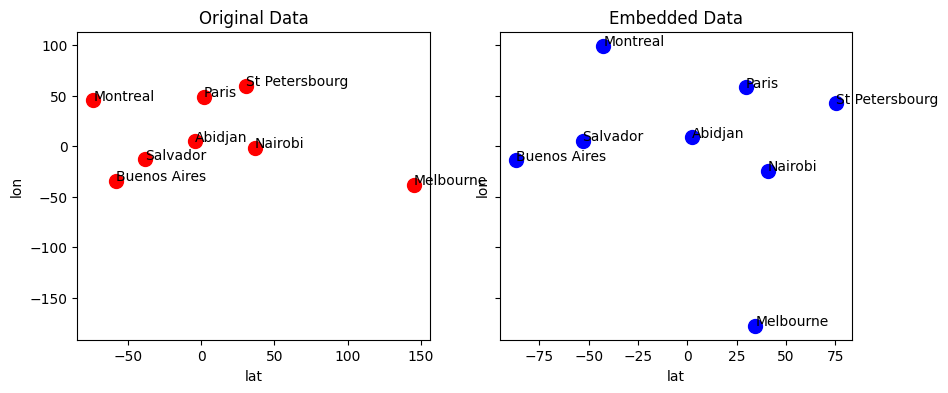

In [8]:
fig, (ax_orig, ax_emb) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10, 4))
plot_points(lat_long_pos, ax_orig, title="Original Data")
plot_points(embedded_df, ax_emb, color="blue", title="Embedded Data")

Where we can see that the relative positions between cities were actually captured quite well. The absolute distances are off and there seems to have been a rotation. But all together this is an interesting result.

### Evaluating distance metrics

We can now apply this algorithm with different distance metrics to see how it performs. For this we build a fucntion to recreate our dataset with a different distance norm

Then we can run the MDS algorithm multiple times, with a different distance metric each time. This clearly shows the difference between interpretability.

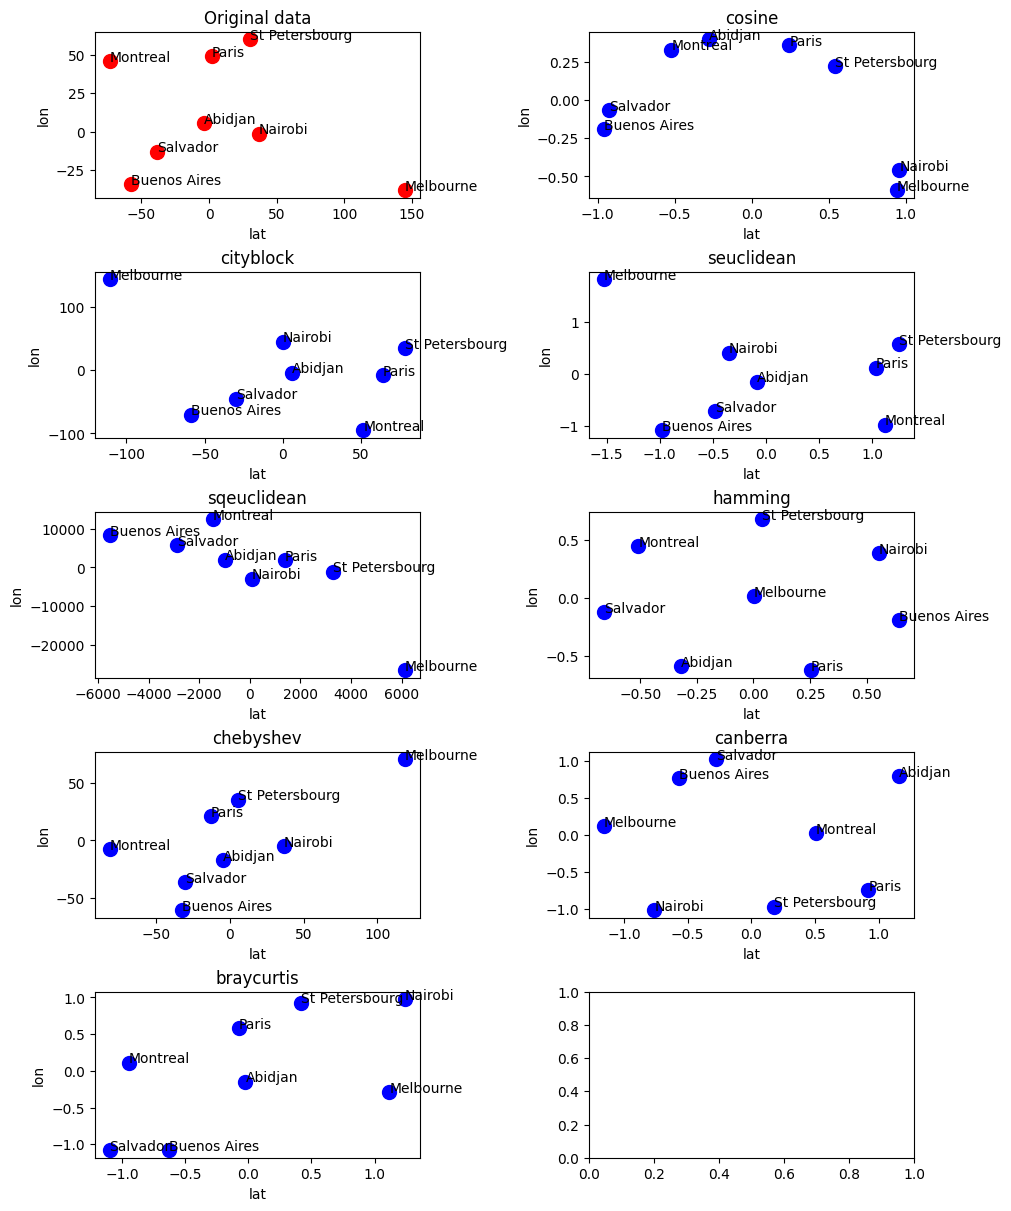

In [ ]:
distance_metrics = ['cosine', 'cityblock', 'seuclidean', 'sqeuclidean',
        'hamming', 'chebyshev', 'canberra', 'braycurtis']

# Create plotting scaffold
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(10, 12), constrained_layout=True)
# linearise into 1D array of axes
axs = axs.ravel()

# Plot the original data as (lta, lon) pairs
plot_points(lat_long_pos, axs[0], title="Original data")

for ax, dist in zip(axs[1:], distance_metrics):
    
    pairwise_distances = squareform(pdist(lat_long_pos.select(["lat", "lon"]), metric=dist))
    distances = pl.DataFrame(pairwise_distances, schema=lat_long_pos['name'].to_list())
    
    embedding = MDS(dissimilarity='precomputed', random_state=0, n_components=2, n_init=4)
    embedded = pl.DataFrame(
        embedding.fit_transform(distances), 
        schema=["lat", "lon"]
        ).hstack([lat_long_pos['name']])
    
    # Plot embeddings as (lat, lon) pairs
    plot_points(embedded, ax, color="blue", title=dist)

## Non-metric MDS

For non-metric MDS we can use the same MDS function from before, by supplying the `metric=False` parameter.

With non-metric MDS we use a different stress function with an additional function $f$:

$$
    S(\mathbf{X}; f) = \sqrt{\frac{\sum_{i<j}\left( f(d_{ij}) - \hat{d}_{ij}\right)^2}{\sum_{i<j} \hat{d}_{ij}^2}}
$$

where $d_{ij}$ is the dissimilarity between points and $\hat{d}_{ij}$ is the euclidean metric between embedded points.

In [ ]:
embedding = MDS(dissimilarity='precomputed', n_components=2, metric=False, random_state=0)

In [28]:
X_transformed = embedding.fit_transform(data)
df_t = pl.DataFrame(X_transformed, schema=['lat', 'lon']).hstack([lat_long_pos['name']])
df_t.head(8)

lat,lon,name
f64,f64,str
-70.610497,-58.538036,"""Buenos Aires"""
-8.121075,63.718413,"""Paris"""
143.391166,-110.784065,"""Melbourne"""
34.24873,78.152712,"""St Petersbourg"""
-3.85882,5.861924,"""Abidjan"""
-94.832862,51.418553,"""Montreal"""
44.703832,0.084915,"""Nairobi"""
-44.920473,-29.914415,"""Salvador"""


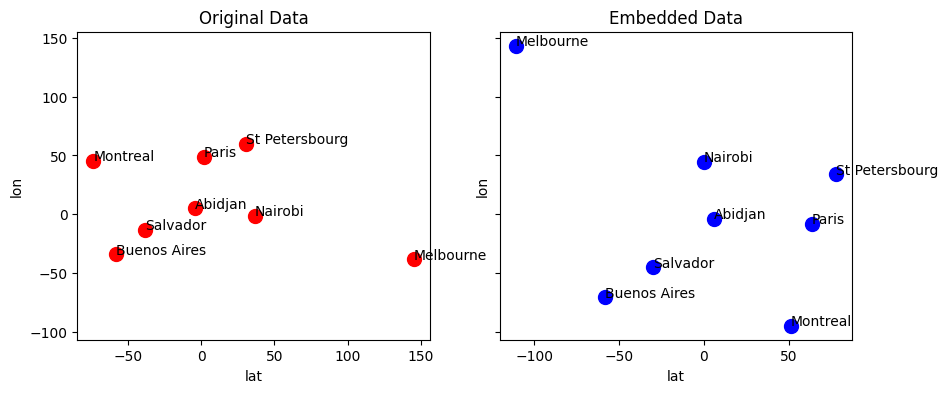

In [31]:
fig, (ax_orig, ax_emb) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10, 4))
plot_points(lat_long_pos, ax_orig, title="Original Data")
plot_points(df_t, ax_emb, color="blue", title="Embedded Data")

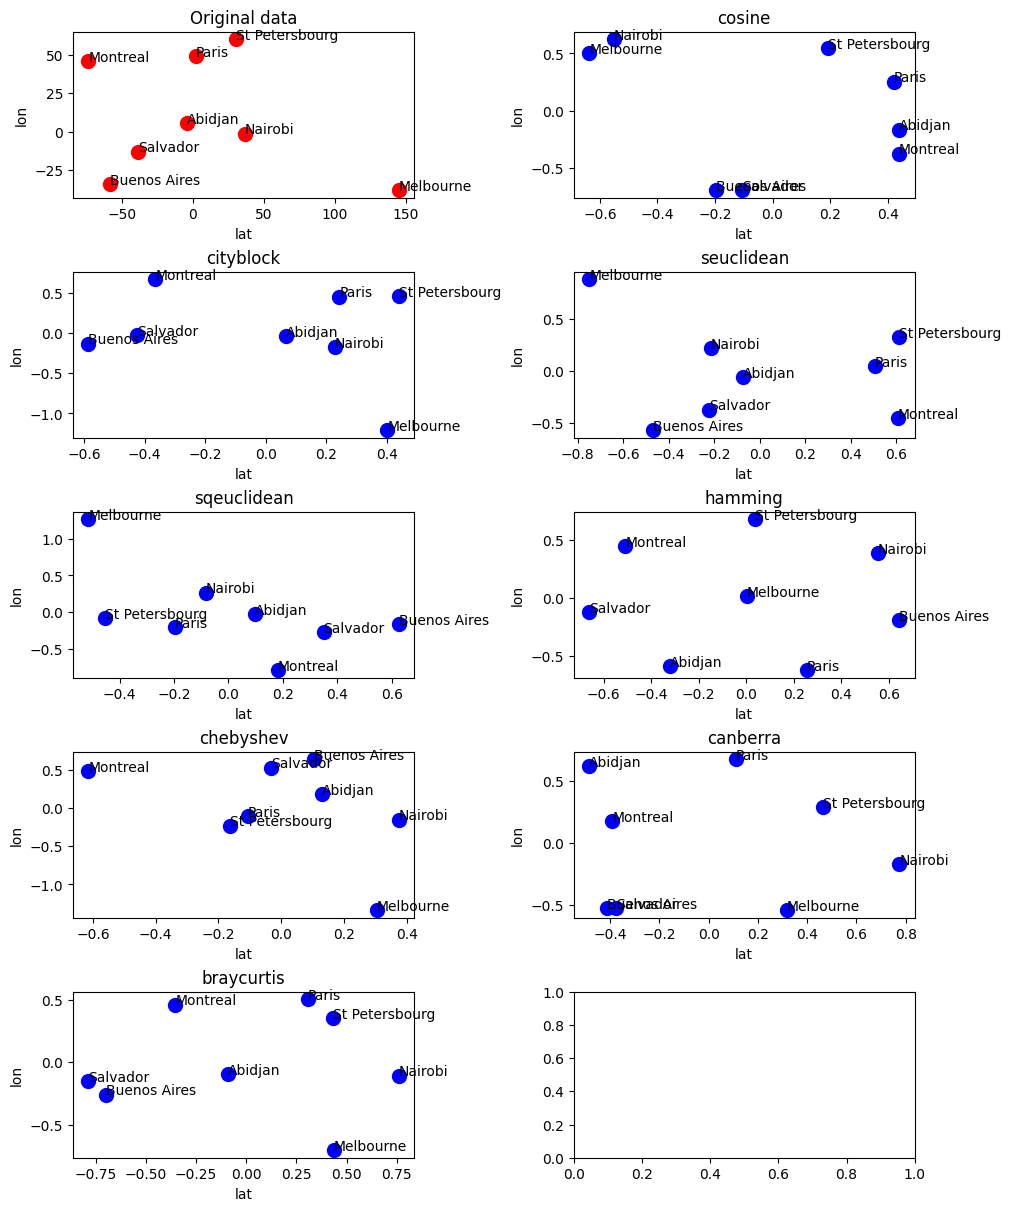

In [32]:
distance_metrics = ['cosine', 'cityblock', 'seuclidean', 'sqeuclidean',
        'hamming', 'chebyshev', 'canberra', 'braycurtis']

# Create plotting scaffold
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(10, 12), constrained_layout=True)
# linearise into 1D array of axes
axs = axs.ravel()

# Plot the original data as (lta, lon) pairs
plot_points(lat_long_pos, axs[0], title="Original data")

for ax, dist in zip(axs[1:], distance_metrics):
    
    pairwise_distances = squareform(pdist(lat_long_pos.select(["lat", "lon"]), metric=dist))
    distances = pl.DataFrame(pairwise_distances, schema=lat_long_pos['name'].to_list())
    
    embedding = MDS(dissimilarity='precomputed', random_state=0, n_components=2, n_init=4, metric=False)
    embedded = pl.DataFrame(
        embedding.fit_transform(distances), 
        schema=["lat", "lon"]
        ).hstack([lat_long_pos['name']])
    
    # Plot embeddings as (lat, lon) pairs
    plot_points(embedded, ax, color="blue", title=dist)

## Dimensionality Reduction with MDS

In [33]:
from sklearn.datasets import load_digits

digits = load_digits(n_class=6)
X, y = digits.data, digits.target
n_samples, n_features = X.shape

In [34]:
print("samples:", n_samples, "features", n_features)

samples: 1083 features 64


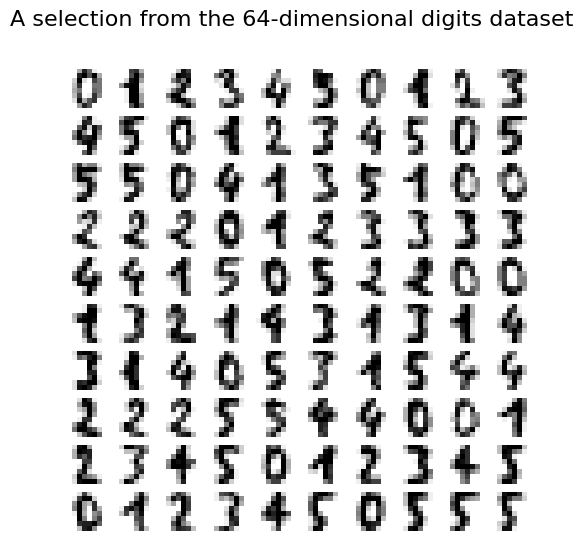

In [35]:
fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(6, 6))
for idx, ax in enumerate(axs.ravel()):
    ax.imshow(X[idx].reshape((8, 8)), cmap=plt.cm.binary)
    ax.axis("off")
_ = fig.suptitle("A selection from the 64-dimensional digits dataset", fontsize=16)

In [36]:
def plot_embedding(X, y, title, ax, digits):
    X = MinMaxScaler().fit_transform(X)
    for digit in digits.target_names:
        ax.scatter(
            *X[y == digit].T,
            marker=f"${digit}$",
            s=60,
            color=plt.cm.Dark2(digit),
            alpha=0.425,
            zorder=2,
        )
    shown_images = np.array([[1.0, 1.0]])  # just something big
    for i in range(X.shape[0]):
        # plot every digit on the embedding
        # show an annotation box for a group of digits
        dist = np.sum((X[i] - shown_images) ** 2, 1)
        if np.min(dist) < 4e-3:
            # don't show points that are too close
            continue
        shown_images = np.concatenate([shown_images, [X[i]]], axis=0)
        imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r), X[i]
        )
        imagebox.set(zorder=1)
        ax.add_artist(imagebox)

    ax.set_title(title)
    ax.axis("off")

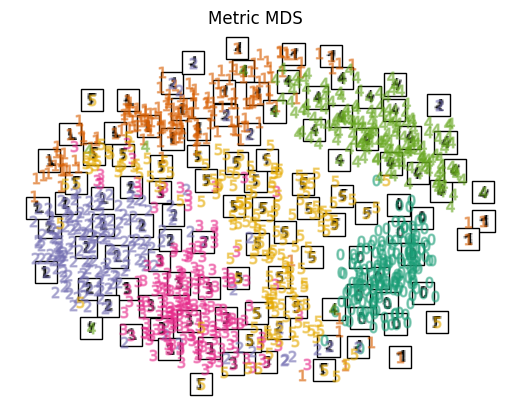

In [37]:
embedding = MDS(n_components=2, n_init=1, max_iter=120, n_jobs=2)
X_transformed = embedding.fit_transform(X)

fig, ax = plt.subplots()
plot_embedding(X_transformed, y, "Metric MDS ", ax, digits)
plt.show()

## TSNE (T-Distributed Stochastic Neighbot Embedding)

TSNE is a method for visualising high-dimensional data in lower dimensions and generally performs better than MDS for visualisation. The method uses randomness to map similarities between datapoints to probabilities and groups similar points together in a lower dimensional subspace.

The method applies the following steps:
1. Similarity Calculation in the original high dimension space
    - The model uses conditional probabilities to measure determine a similarity metric as a probability distribution
2. Mapping to low dimension
    - Then a similar probability distribution is created in the low dimension subspace
3. Optimization
    - The model then shifts the positions of datapoints to minimize the difference between the low-D and high-D probability distributions.

This method is able to capture non-linear features, preserves local structure and is mainly meant for visualisation. The clusters resulting from the model are globally meaningful, but the between cluster distances are not. 

In [38]:
X_embedded = TSNE(n_components=2, init='random').fit_transform(X)

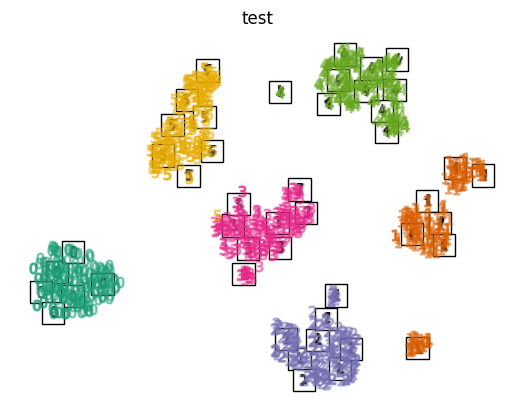

In [39]:
fig, ax = plt.subplots()
plot_embedding(X_embedded, y, "test", ax, digits)
plt.show()